## 1D Microwave with different materials

Consider the Helmholtz equation on the unit interval: 

\begin{alignat}{3}
\begin{aligned}
  \partial_{xx} u + \frac{\omega^{2}}{c(x)^{2}}u &= f   &  \quad  \text{ on }    [0,1],  \\
   u(0) = 1  \\
   u \;  \text{fulfills radiation condition at } x = 0 \text{ and } x = 1 \\
\end{aligned}  
\end{alignat}

We discretize $[0,1]$ with a cartesian grid with spacing $h = 1/(n+1)$.

### direct solver solution with FEM

In [1]:
from math import pi
import scipy
import scipy.sparse.linalg

M = 5
k=2*M
omega = k*2*pi
order = 2
n = int(32*k/order)
print("n =", n)
dirichlet = [1]
solver = "pardiso"

n = 160


#### 1D Meshing in Netgen

In [2]:
import netgen.meshing
from netgen.meshing import *

mesh = Mesh(dim=1)
pids = []
for i in range(n+1):
    pids.append (mesh.Add (MeshPoint(Pnt(2*i/n, 0, 0))))
for i in range(n):
    mesh.Add(Element1D([pids[i],pids[i+1]],index=1))
mesh.Add (Element0D( pids[0], index=1))
mesh.Add (Element0D( pids[n], index=2))
#mesh.AddPointIdentification(pids[0],pids[n],1,2)
from ngsolve import *
mesh = Mesh(mesh) 

#### Matplot drawing for NGSolve-CoefficientFunctions

In [3]:
import matplotlib.pyplot as plt

def draw_matplotlib(coefs, n_s=1000):
    h_s = 2.0/n_s # sampling width (for drawing)
    x_v = [2*i/n for i in range(n+1)]
    x_s = [i*h_s for i in range(n_s+1)]
    for f,name in coefs:
        plt.plot(x_s,[f(mesh(s)) for s in x_s],label=name)
    plt.plot(x_v,[0 for v in x_v],'|',label='vertices')
    plt.legend()
    plt.show()

#### problem data (CoefficientFunctions)

In [4]:
from ngsolve import *
c1 = CoefficientFunction(1)
c2 = IfPos(x-0.5,M/(M-0.5),1)

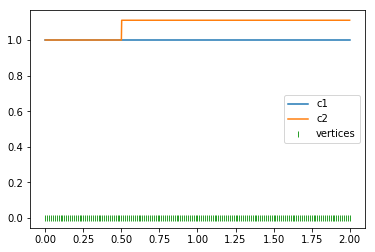

In [5]:
draw_matplotlib([[c1,"c1"],[c2,"c2"]])

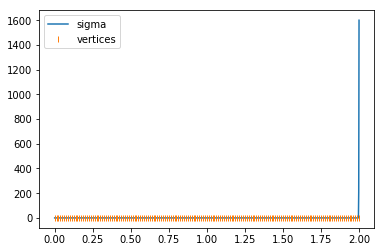

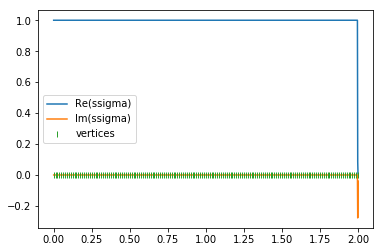

In [6]:
eta = 1/(order*n) # pml
C = 5 # pml

sigma = CoefficientFunction(0.0)
if not 1 in dirichlet:
    sigma += IfPos(eta-x,C/eta*((x-eta)/(eta))**2,0)
if not 2 in dirichlet:
    sigma += IfPos(eta-(2-x),C/eta*((2-x-eta)/(eta))**2,0)

draw_matplotlib([[sigma,"sigma"]])

s = lambda sigma : omega / (omega+1J*sigma)

draw_matplotlib([[s(sigma).real,"Re(ssigma)"],[s(sigma).imag,"Im(ssigma)"]])


#### Solving the variational problem:

In [7]:
fes = H1(mesh, complex=True,  order=order, dirichlet=dirichlet)
u,v = fes.TnT()
gfu1 = GridFunction (fes)
gfu2 = GridFunction (fes)

In [8]:
a1 = BilinearForm (fes, symmetric=True)
a1 += SymbolicBFI (c1**2*s(sigma)*grad(u)*grad(v) )
a1 += SymbolicBFI (-omega**2/(s(sigma))*u*v)
a1.Assemble()

a2 = BilinearForm (fes, symmetric=True)
a2 += SymbolicBFI (c2**2*s(sigma)*grad(u)*grad(v) )
a2 += SymbolicBFI (-omega**2/(s(sigma))*u*v)
a2.Assemble()
#print(a.mat)

In [9]:
f = LinearForm (fes)
#f += SymbolicLFI (-source*v/s(sigma))
f.Assemble()

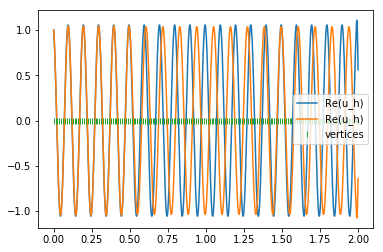

(1.0053989795354825-0.02065314834767194j) (-1.00369498429977+0.01667148978293071j)


In [10]:
res = gfu1.vec.CreateVector()
gfu1.vec[:] = 0.0
gfu1.vec[0] = 1.0
gfu2.vec[:] = 0.0
gfu2.vec[0] = 1.0
res.data = f.vec - a1.mat * gfu1.vec
invA1 = a1.mat.Inverse(freedofs=fes.FreeDofs(), inverse=solver)
gfu1.vec.data += invA1 * res
res.data = f.vec - a2.mat * gfu2.vec
invA2 = a2.mat.Inverse(freedofs=fes.FreeDofs(), inverse=solver)
gfu2.vec.data += invA2 * res
#draw_matplotlib([[gfu.real,"Re(u_h)"],[gfu.imag,"Im(u_h)"]])
draw_matplotlib([[gfu1.real,"Re(u_h)"],[gfu2.real,"Re(u_h)"]])

print(gfu1(mesh(1.0)),gfu2(mesh(1.0)))